### Description:  This script produces Figure 14 (pseudo RHIs of reflectivity field overlaid with VHF sources in and near the plane of RHI with their polarity indicated). Creates a panel plot with subplots indicating different times of analysis

In [1]:
import glob
import math
import os
import warnings
from datetime import datetime, timedelta
from operator import itemgetter

import matplotlib
import matplotlib.pyplot as plt
import netCDF4
import numpy as np

# import tables
import pandas as pd
import pyart
from matplotlib.dates import DateFormatter
from numpy import ones, vstack
from numpy.linalg import lstsq

from lmatools.coordinateSystems import (
    GeographicSystem,
    MapProjection,
    RadarCoordinateSystem,
)
from may19_2013_obs_analysis.lma_parsing import (
    ceil,
    grab_time_intervals,
    point_to_line_dist,
    scan_vol_time,
    sec2time,
)
from may19_2013_obs_analysis.wsr88d_parsing import interval, plot_point

warnings.filterwarnings("ignore")

matplotlib.rc("xtick", labelsize=15)
matplotlib.rc("ytick", labelsize=15)

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Load KTLX radar files for May 19, 2013 case
source_dir_radar = os.path.expanduser("~/Desktop/mount/May_19_2013_all_stuff/KTLX_data")
files_radar = sorted(glob.glob(source_dir_radar + "/*V06", recursive=True))

In [4]:
# We are interested in KTLX level II data available in the volume scan beginning at 211920 UTC

files_rad_interest = list(
    itemgetter(15, 16, 17, 18, 20, 21, 22, 23, 24, 25)(files_radar)
)
files_rad_interest = [files_rad_interest[3]]

# Load charge classification file to plot individual classified
# VHF source on top of pseudoRHIs from radar

# Load charge classification file 2110_2120 UTC
file_charge2 = os.path.expanduser(
    "../data/processed/charge_classification_files/charge_classification_2110_2120.txt"
)

data_charge2 = pd.read_csv(
    file_charge2,
    skiprows=12,
    delim_whitespace=True,
    names=[
        "time",
        "lat",
        "lon",
        "alt",
        "reduced_chi2",
        "stations",
        "Power",
        "charge",
        "mask",
    ],
)
data_charge2 = data_charge2.drop(columns="mask")

# Load charge classification file 2120_2123 UTC
file_charge = os.path.expanduser(
    "../data/processed/charge_classification_files/charge_classification_2120_2123.txt"
)

data_charge = pd.read_csv(
    file_charge,
    skiprows=12,
    delim_whitespace=True,
    names=[
        "time",
        "lat",
        "lon",
        "alt",
        "reduced_chi2",
        "stations",
        "Power",
        "charge",
        "mask",
    ],
)
data_charge = data_charge.drop(columns="mask")

# Load charge classification file 2130_2140 UTC
file_charge3 = os.path.expanduser(
    "../data/processed/charge_classification_files/charge_classification_2130_2140.txt"
)

data_charge3 = pd.read_csv(
    file_charge3,
    skiprows=12,
    delim_whitespace=True,
    names=[
        "time",
        "lat",
        "lon",
        "alt",
        "reduced_chi2",
        "stations",
        "Power",
        "charge",
        "mask",
    ],
)
data_charge3 = data_charge3.drop(columns="mask")

# Load charge classification file 2140_2150 UTC
file_charge4 = os.path.expanduser(
    "../data/processed/charge_classification_files/charge_classification_2140_2150.txt"
)

data_charge4 = pd.read_csv(
    file_charge4,
    skiprows=12,
    delim_whitespace=True,
    names=[
        "time",
        "lat",
        "lon",
        "alt",
        "reduced_chi2",
        "stations",
        "Power",
        "charge",
        "mask",
    ],
)
data_charge4 = data_charge4.drop(columns="mask")

# merge all four charge classification files to produce a single DataFrame
merged_data_charge = data_charge.append(
    [data_charge2, data_charge3, data_charge4], sort=False
)

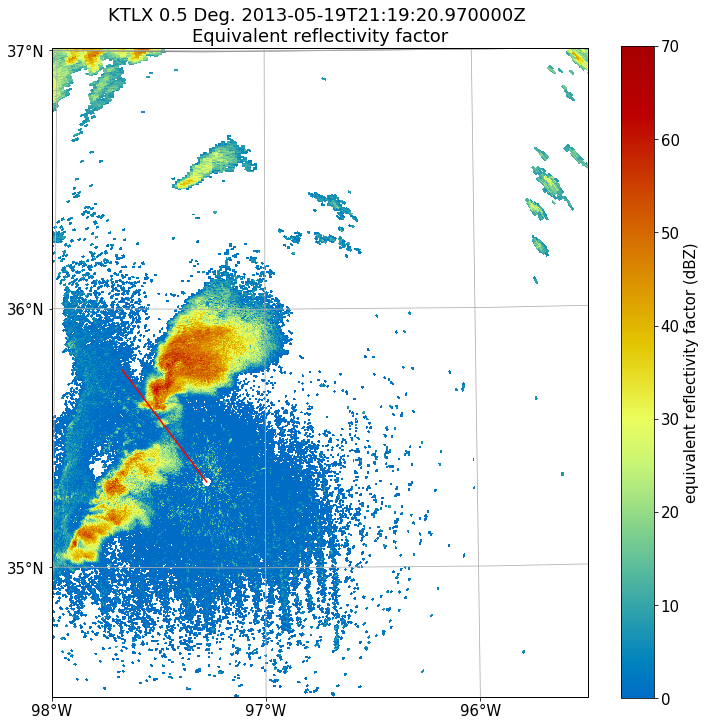

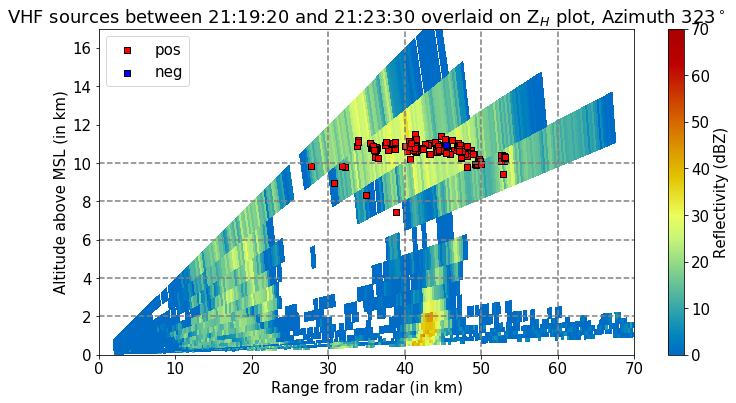

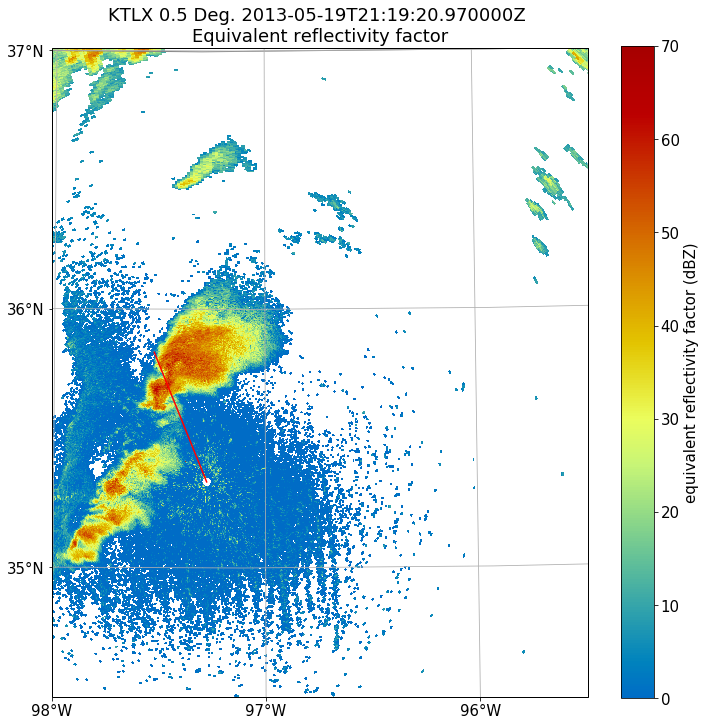

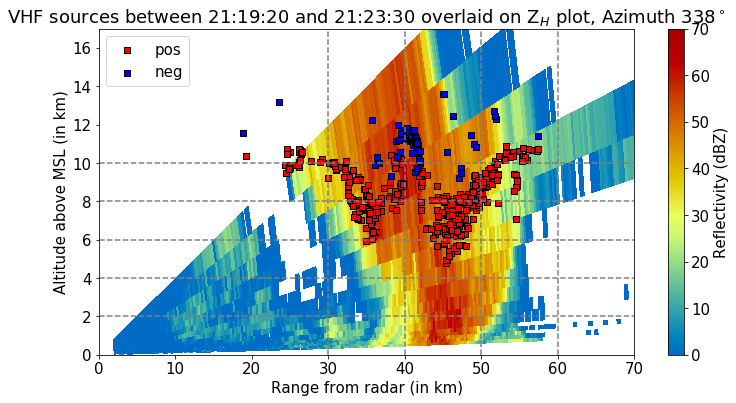

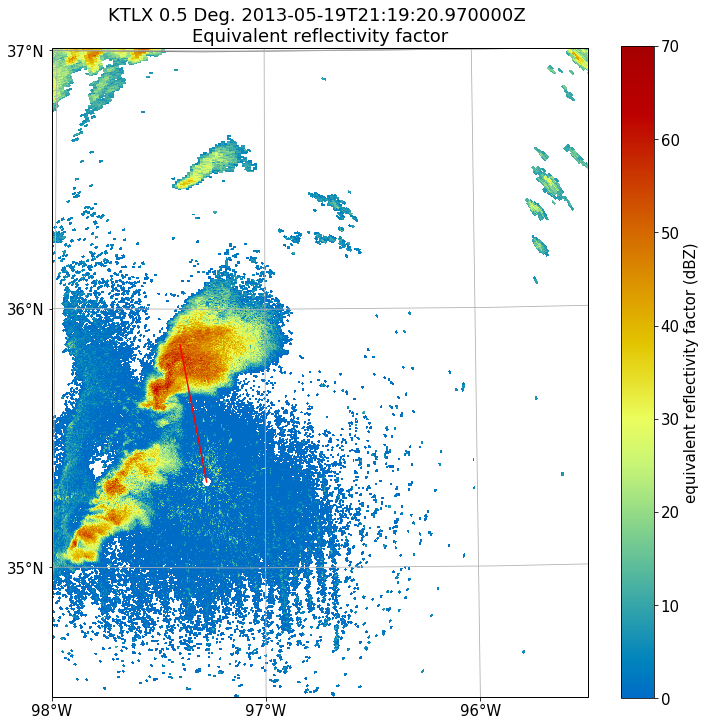

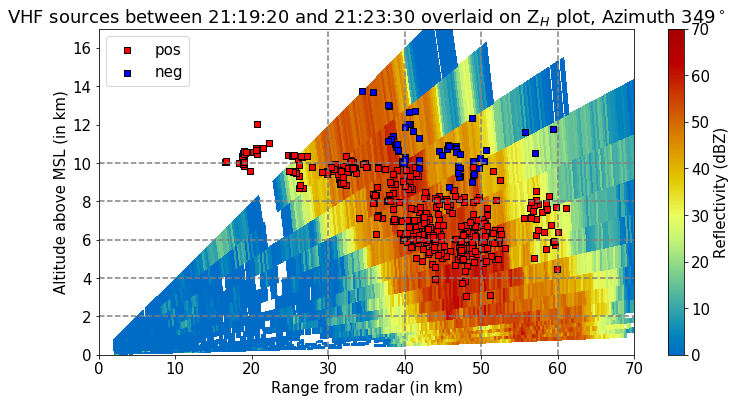

In [5]:
threshold = 0.25  # This threshold means all VHF sources within 500 m on either side of azimuth will be considered for overlay

for f in files_rad_interest:
    radar = pyart.io.read(f)
    display = pyart.graph.RadarMapDisplay(radar)

    az_range = [323, 338, 349]

    for azimuth in az_range:

        fig = plt.figure(figsize=(12, 12))

        endx, endy = plot_point((0, 0), azimuth, 60)

        display.plot_ppi_map(
            "reflectivity",
            vmin=0,
            vmax=70,
            min_lon=-98,
            max_lon=-95.5,
            min_lat=34.5,
            max_lat=37,
        )
        display.plot_line_xy([0, endx], [0, endy])

        plt.show()

        data, x, y, z = display._get_azimuth_rhi_data_x_y_z(
            "reflectivity",
            azimuth,
            edges=True,
            mask_tuple=None,
            filter_transitions=True,
            gatefilter=None,
        )
        R = np.sqrt(x ** 2 + y ** 2)

        x_1d = x.flatten()
        y_1d = y.flatten()
        z_1d = z.flatten()

        # Calculations to find the distance between
        # a given point and a given line in 2 D.

        # Since there is a slight difference between the x,y coordinates of last point on 1st scan and last point
        points = [(x[0, :][0], y[0, :][0]), (x[-1, :][-1], y[0, :][-1])]
        # on the highest scan, that's why went this this approach.
        x_coords, y_coords = zip(*points)
        A = vstack([x_coords, ones(len(x_coords))]).T
        m, c1 = lstsq(A, y_coords)[0]

        out = interval(radar)
        interval_left1, interval_left2, interval_right1, interval_right2 = out
        charge_pt_mask = (merged_data_charge["time"] > interval_left1) & (
            merged_data_charge["time"] < interval_right2
        )  # filtering only those flashes which occurred during radar scan
        filtered_charge = merged_data_charge[charge_pt_mask]

        # filter to further positively charged sources after time filter above
        pos_mask = filtered_charge["charge"] == 3
        pos_charge = filtered_charge[pos_mask]
        pos_charge_lat = pos_charge["lat"]
        pos_charge_lon = pos_charge["lon"]
        pos_charge_alt = pos_charge["alt"]
        pos_charge_alt = np.asarray(pos_charge_alt)
        pos_x, pos_y = pyart.core.transforms.geographic_to_cartesian_aeqd(
            pos_charge_lon,
            pos_charge_lat,
            lat_0=radar.latitude["data"],
            lon_0=radar.longitude["data"],
        )

        # filter to further negatively charged sources after time filter above
        neg_mask = filtered_charge["charge"] == -3
        neg_charge = filtered_charge[neg_mask]
        neg_charge_lat = neg_charge["lat"]
        neg_charge_lon = neg_charge["lon"]
        neg_charge_alt = neg_charge["alt"]
        neg_charge_alt = np.asarray(neg_charge_alt)
        neg_x, neg_y = pyart.core.transforms.geographic_to_cartesian_aeqd(
            neg_charge_lon,
            neg_charge_lat,
            lat_0=radar.latitude["data"],
            lon_0=radar.longitude["data"],
        )

        # next step is to include only those flashes which occurred with 1-2 km of the x-section

        li_pos = []
        for i in range(len(pos_x)):
            point = [pos_x[i] / 1000.0, pos_y[i] / 1000.0]
            line = [x_1d[0], y_1d[0]], [x_1d[-1], y_1d[-1]]
            line1 = np.asarray(line)
            disti = point_to_line_dist(point, line1)
            li_pos.append(disti)

        li_neg = []
        for i in range(len(neg_x)):
            point = [neg_x[i] / 1000.0, neg_y[i] / 1000.0]
            line = [x_1d[0], y_1d[0]], [x_1d[-1], y_1d[-1]]
            line1 = np.asarray(line)
            disti = point_to_line_dist(point, line1)
            li_neg.append(disti)

        idx_pos = np.where(np.asarray(li_pos) <= threshold)
        idx_neg = np.where(np.asarray(li_neg) <= threshold)

        R_pos = np.sqrt((pos_x[idx_pos] / 1000.0) ** 2 + (pos_y[idx_pos] / 1000.0) ** 2)
        R_neg = np.sqrt((neg_x[idx_neg] / 1000.0) ** 2 + (neg_y[idx_neg] / 1000.0) ** 2)

        fig = plt.figure(figsize=(12, 6))
        zh = plt.pcolormesh(R, z, data, vmin=0, vmax=70, cmap="pyart_HomeyerRainbow")

        plt.scatter(
            R_pos,
            pos_charge_alt[idx_pos] / 1000.0,
            c="r",
            marker="s",
            label="pos",
            edgecolors="k",
        )
        plt.scatter(
            R_neg,
            neg_charge_alt[idx_neg] / 1000.0,
            c="b",
            marker="s",
            label="neg",
            edgecolors="k",
        )

        plt.xlabel("Range from radar (in km)")
        plt.ylabel("Altitude above MSL (in km)")
        for j in [2, 4, 6, 8, 10]:
            plt.axhline(y=j, color="gray", linestyle="--")
        for k in [30, 40, 50, 60]:
            plt.axvline(x=k, color="gray", linestyle="--")

        # plt.axhline(y = 8 ,color='k',linestyle='--')
        plt.title(
            "VHF sources between %s and %s overlaid on Z$_{H}$ plot, Azimuth %s$^\circ$"
            % (sec2time(interval_left1)[0:8], sec2time(interval_right2)[0:8], azimuth)
        )
        plt.xlim(0, 70)
        plt.ylim(0, 17)
        plt.legend(loc="best")
        plt.colorbar(mappable=zh, label="Reflectivity (dBZ)")
        plt.show()

<Figure size 864x864 with 0 Axes>

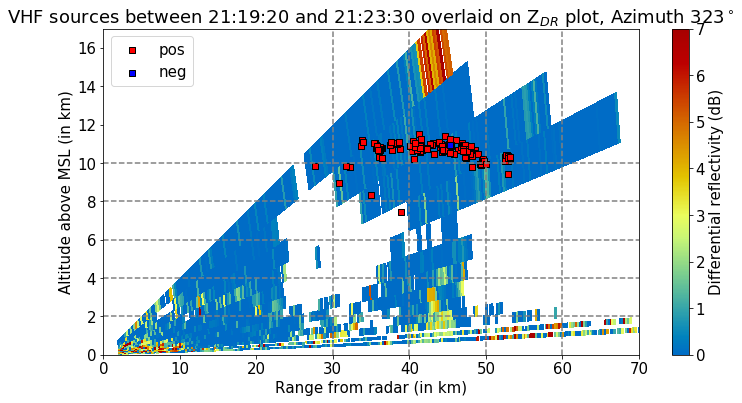

<Figure size 864x864 with 0 Axes>

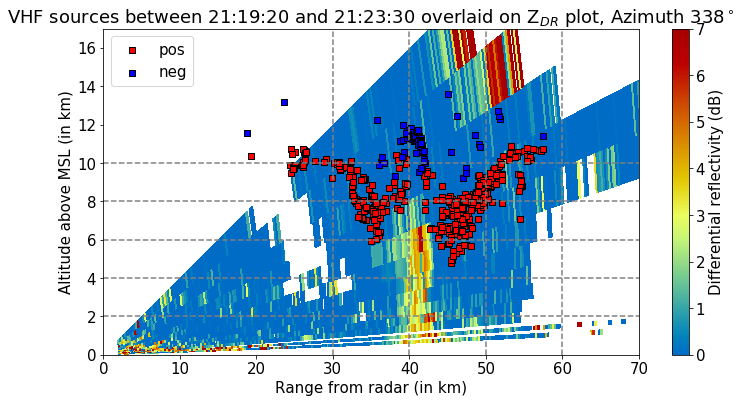

<Figure size 864x864 with 0 Axes>

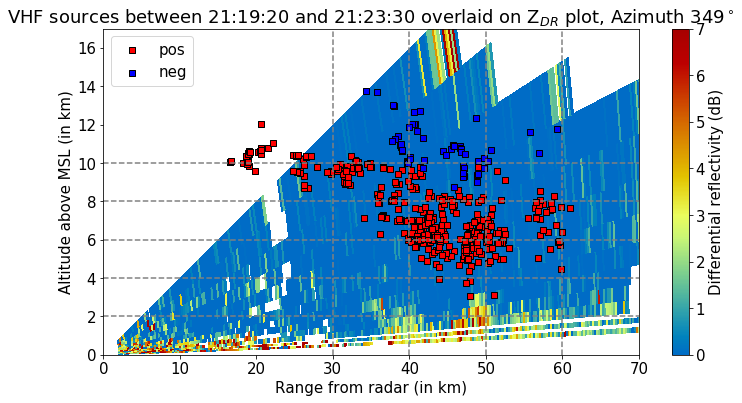

In [6]:
threshold = 0.25  # This threshold means all VHF sources within 500 m on either side of azimuth will be considered for overlay

for f in files_rad_interest:
    radar = pyart.io.read(f)
    display = pyart.graph.RadarMapDisplay(radar)

    az_range = [323, 338, 349]
    for azimuth in az_range:

        fig = plt.figure(figsize=(12, 12))

        data, x, y, z = display._get_azimuth_rhi_data_x_y_z(
            "differential_reflectivity",
            azimuth,
            edges=True,
            mask_tuple=None,
            filter_transitions=True,
            gatefilter=None,
        )
        R = np.sqrt(x ** 2 + y ** 2)

        x_1d = x.flatten()
        y_1d = y.flatten()
        z_1d = z.flatten()

        # Calculations to find the distance between
        # a given point and a given line in 2 D.

        # Since there is a slight difference between the x,y coordinates of last point on 1st scan and last point
        points = [(x[0, :][0], y[0, :][0]), (x[-1, :][-1], y[0, :][-1])]
        # on the highest scan, that's why went this this approach.
        x_coords, y_coords = zip(*points)
        A = vstack([x_coords, ones(len(x_coords))]).T
        m, c1 = lstsq(A, y_coords)[0]

        out = interval(radar)
        interval_left1, interval_left2, interval_right1, interval_right2 = out
        charge_pt_mask = (merged_data_charge["time"] > interval_left1) & (
            merged_data_charge["time"] < interval_right2
        )  # filtering only those flashes which occurred during radar scan
        filtered_charge = merged_data_charge[charge_pt_mask]

        # filter to further positively charged sources after time filter above
        pos_mask = filtered_charge["charge"] == 3
        pos_charge = filtered_charge[pos_mask]
        pos_charge_lat = pos_charge["lat"]
        pos_charge_lon = pos_charge["lon"]
        pos_charge_alt = pos_charge["alt"]
        pos_charge_alt = np.asarray(pos_charge_alt)
        pos_x, pos_y = pyart.core.transforms.geographic_to_cartesian_aeqd(
            pos_charge_lon,
            pos_charge_lat,
            lat_0=radar.latitude["data"],
            lon_0=radar.longitude["data"],
        )

        # filter to further negatively charged sources after time filter above
        neg_mask = filtered_charge["charge"] == -3
        neg_charge = filtered_charge[neg_mask]
        neg_charge_lat = neg_charge["lat"]
        neg_charge_lon = neg_charge["lon"]
        neg_charge_alt = neg_charge["alt"]
        neg_charge_alt = np.asarray(neg_charge_alt)
        neg_x, neg_y = pyart.core.transforms.geographic_to_cartesian_aeqd(
            neg_charge_lon,
            neg_charge_lat,
            lat_0=radar.latitude["data"],
            lon_0=radar.longitude["data"],
        )

        # next step is to include only those flashes which occurred with 1-2 km of the x-section

        li_pos = []
        for i in range(len(pos_x)):
            point = [pos_x[i] / 1000.0, pos_y[i] / 1000.0]
            line = [x_1d[0], y_1d[0]], [x_1d[-1], y_1d[-1]]
            line1 = np.asarray(line)
            disti = point_to_line_dist(point, line1)
            li_pos.append(disti)

        li_neg = []
        for i in range(len(neg_x)):
            point = [neg_x[i] / 1000.0, neg_y[i] / 1000.0]
            line = [x_1d[0], y_1d[0]], [x_1d[-1], y_1d[-1]]
            line1 = np.asarray(line)
            disti = point_to_line_dist(point, line1)
            li_neg.append(disti)

        idx_pos = np.where(np.asarray(li_pos) <= threshold)
        idx_neg = np.where(np.asarray(li_neg) <= threshold)

        R_pos = np.sqrt((pos_x[idx_pos] / 1000.0) ** 2 + (pos_y[idx_pos] / 1000.0) ** 2)
        R_neg = np.sqrt((neg_x[idx_neg] / 1000.0) ** 2 + (neg_y[idx_neg] / 1000.0) ** 2)

        fig = plt.figure(figsize=(12, 6))
        zdr = plt.pcolormesh(R, z, data, vmin=0, vmax=7, cmap="pyart_HomeyerRainbow")

        plt.scatter(
            R_pos,
            pos_charge_alt[idx_pos] / 1000.0,
            c="r",
            marker="s",
            label="pos",
            edgecolors="k",
        )
        plt.scatter(
            R_neg,
            neg_charge_alt[idx_neg] / 1000.0,
            c="b",
            marker="s",
            label="neg",
            edgecolors="k",
        )

        plt.xlabel("Range from radar (in km)")
        plt.ylabel("Altitude above MSL (in km)")
        for j in [2, 4, 6, 8, 10]:
            plt.axhline(y=j, color="gray", linestyle="--")
        for k in [30, 40, 50, 60]:
            plt.axvline(x=k, color="gray", linestyle="--")

        # plt.axhline(y = 8 ,color='k',linestyle='--')
        plt.title(
            "VHF sources between %s and %s overlaid on Z$_{DR}$ plot, Azimuth %s$^\circ$"
            % (sec2time(interval_left1)[0:8], sec2time(interval_right2)[0:8], azimuth)
        )
        plt.xlim(0, 70)
        plt.ylim(0, 17)
        plt.legend(loc="best")
        plt.colorbar(mappable=zdr, label="Differential reflectivity (dB)")

        plt.show()